In [1]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings("ignore")
import re
from datetime import datetime, timedelta
from pyxirr import xirr

**helper**

In [2]:
# -------------------------------
# Text / column normalization
# -------------------------------
def normalize_text(s: str) -> str:
    """Normalize text to lowercase, remove special chars, replace spaces with underscores."""
    s = str(s).strip().lower()
    s = re.sub(r'[^a-z0-9]+', '_', s)
    s = re.sub(r'_+', '_', s).strip('_')
    return s

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Apply normalization to all column names in a dataframe."""
    df.columns = [normalize_text(c) for c in df.columns]
    return df


# -------------------------------
# Convert selected columns to float safely
# -------------------------------
def convert_to_float(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """Convert listed columns to float, replacing invalid entries ('-', '', nan, etc.) with 0."""
    for col in cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str).str.strip()
                .replace(['-', '', 'nan', 'None'], '0')
                .astype(float)
            )
    return df


# -------------------------------
# Convert percentage values to decimals
# -------------------------------
def convert_percentages(df: pd.DataFrame, value_col='value', unit_col='unit') -> pd.DataFrame:
    """For rows with unit = '%', divide value by 100."""
    if unit_col in df.columns:
        df.loc[df[unit_col].astype(str).str.strip() == '%', value_col] = (
            df[value_col] / 100
        )
    return df

# ----------------------------------------------------------------
# Extract assumptions
# ----------------------------------------------------------------

def get_val(df: pd.DataFrame, name: str, 
            key_col: str = "assumptions", 
            val_col: str = "value", 
            single: bool = True):
    
    if key_col not in df.columns or val_col not in df.columns:
        raise KeyError(f"Expected columns '{key_col}' and '{val_col}' not found in DataFrame")

    vals = (
        df.loc[df[key_col].astype(str).str.lower() == name.lower(), val_col]
        .astype(float, errors="ignore")
        .tolist()
    )

    if single:
        return float(vals[0]) if vals else np.nan
    else:
        return [float(v) for v in vals] if vals else []

**Inputs**

In [3]:
df_load_profile = pd.read_csv(r"D:\GH2\Energy\input\solar_wind_profile.csv")
df_assumptions = pd.read_csv(r"D:\GH2\Energy\input\assumptions.csv")
df_static_normalized = pd.read_csv(r"D:\GH2\Energy\input\df_static_normalized.csv")

**Load Profile**

In [4]:
# Normalize column names
df_load_profile = normalize_columns(df_load_profile)

# Convert Power & Wind generation columns to float (handling '-' etc.)
cols_to_convert = [c for c in df_load_profile.columns if 'power_mwac' in c or 'wind_gen' in c]
df_load_profile = convert_to_float(df_load_profile, cols_to_convert)

# Preview result
print("✅ Solar–Wind Profile cleaned successfully.\n")
print(df_load_profile.dtypes)
display(df_load_profile.head())

✅ Solar–Wind Profile cleaned successfully.

month                int64
day                  int64
min                 object
power_mwac         float64
wind_generation    float64
dtype: object


,month,day,min,power_mwac,wind_generation
0,1,1,00:00:00,0.0,0.685433
1,1,1,00:15:00,0.0,0.685433
2,1,1,00:30:00,0.0,0.685433
3,1,1,00:45:00,0.0,0.685433
4,1,1,01:00:00,0.0,0.685433


**Assumptions**

In [5]:
# Normalize columns and assumption names
df_assumptions = normalize_columns(df_assumptions)
df_assumptions['assumptions'] = df_assumptions['assumptions'].apply(normalize_text)

# Convert percentage values to decimals
df_assumptions = convert_percentages(df_assumptions, value_col='value', unit_col='unit')

# Keep only assumptions and values, ensure float dtype
df_assumptions = df_assumptions[['assumptions', 'value']]
df_assumptions['value'] = df_assumptions['value'].astype(float)

# Preview
print("✅ Assumptions cleaned successfully.\n")
print(df_assumptions.dtypes)
display(df_assumptions)

✅ Assumptions cleaned successfully.

assumptions     object
value          float64
dtype: object


,assumptions,value
0,peak_hrs,6.0000
1,peak_hrs,7.0000
2,peak_hrs,8.0000
3,peak_hrs,18.0000
4,solar_capacity,1750.0000
5,wind_capacity,700.0000
6,max_capacity_bess,1000.0000
7,round_trip_eff_bess,0.8500
8,aux_consumption,0.0004
9,dtl_losses,0.0003


**Calculation Results**

In [6]:
# ============================================================
#  Function: generate_main_dataframe
# ============================================================
def generate_main_dataframe(df_load_profile: pd.DataFrame, df_assumptions: pd.DataFrame) -> pd.DataFrame:
    """
    Generate the GH2 master table with all 21 columns (plus day),
    using df_load_profile (month × day × 15-min slots) and df_assumptions.
    
    """

    peak_hrs = get_val(df_assumptions, "peak_hrs", single=False)
    print("peak_hrs:", peak_hrs)

    # Other assumption parameters
    solar_capacity       = get_val(df_assumptions, "solar_capacity")
    wind_capacity        = get_val(df_assumptions, "wind_capacity")
    max_capacity_bess    = get_val(df_assumptions, "max_capacity_bess")
    round_trip_eff_bess  = get_val(df_assumptions, "round_trip_eff_bess")
    aux_consumption      = get_val(df_assumptions, "aux_consumption")
    dtl_losses           = get_val(df_assumptions, "dtl_losses")
    bid_capacity_peak    = get_val(df_assumptions, "bid_capacity_peak")
    bid_capacity_offpeak = get_val(df_assumptions, "bid_capacity_offpeak")

    # ----------------------------------------------------------------
    #  STEP 2: Base structure — month × day × slot
    # ----------------------------------------------------------------
    df = df_load_profile.copy()
    df = df.sort_values(by=["month", "day", "min"]).reset_index(drop=True)

    # Ensure column dtypes are correct
    df["month"] = df["month"].astype(int)
    df["day"] = df["day"].astype(int)
    df["hour"] = pd.to_datetime(df["min"], format="%H:%M:%S").dt.hour + 1
    df["slot_no"] = df.index + 1  # running slot index

    # ----------------------------------------------------------------
    #  STEP 3: Generation calculations (vectorized)
    # ----------------------------------------------------------------
    df["solar"] = solar_capacity * df["power_mwac"] / 4
    df["wind"] = wind_capacity * df["wind_generation"] / 4
    df["total_generation"] = (df["solar"] + df["wind"]) * (1 - aux_consumption) * (1 - dtl_losses)

    # ----------------------------------------------------------------
    #  STEP 4: Peak / Off-peak and Discom requirement
    # ----------------------------------------------------------------
    df["peak_offpeak"] = np.where(df["hour"].isin(peak_hrs), "Peak", "Off-Peak")
    df["discom_requirement"] = np.where(
        df["peak_offpeak"] == "Peak", bid_capacity_peak, bid_capacity_offpeak
    )

    # ----------------------------------------------------------------
    #  STEP 5: Surplus / Shortfall
    # ----------------------------------------------------------------
    df["surplus_shortfall"] = df["total_generation"] - df["discom_requirement"]

    # ----------------------------------------------------------------
    #  STEP 6: Pre-allocate BESS arrays for performance
    # ----------------------------------------------------------------
    n = len(df)
    opening = np.zeros(n)
    energy_avail_chg = np.zeros(n)
    energy_used = np.zeros(n)
    total_energy = np.zeros(n)
    extractable = np.zeros(n)
    discharge = np.zeros(n)
    closing = np.zeros(n)
    energy_left = np.zeros(n)
    discom_met = np.zeros(n)
    shortfall = np.zeros(n)
    availability = np.zeros(n)
    status = np.empty(n, dtype=object)

    # ----------------------------------------------------------------
    #  STEP 7: Iterative BESS logic (chronological dependency)
    # ----------------------------------------------------------------
    for i in range(n):
        prev_closing = closing[i - 1] if i > 0 else 0
        surplus = df.at[i, "surplus_shortfall"]

        # Determine charge/discharge status
        if prev_closing <= 0:
            status[i] = "No Action"
        elif surplus <= 0:
            status[i] = "Discharge"
        else:
            status[i] = "Charge"

        # Energy available for charging
        energy_avail_chg[i] = max(0, surplus)

        # Energy used for charging
        if prev_closing == 0:
            energy_used[i] = min(max_capacity_bess, energy_avail_chg[i])
        elif prev_closing == max_capacity_bess:
            energy_used[i] = 0
        elif prev_closing < max_capacity_bess:
            energy_used[i] = energy_avail_chg[i]
        else:
            energy_used[i] = 0

        # Total energy in battery
        total_energy[i] = min(max_capacity_bess, prev_closing + energy_used[i])

        # Extractable energy (apply efficiency)
        extractable[i] = total_energy[i] * round_trip_eff_bess

        # Actual discharge
        discharge[i] = min(-surplus, extractable[i]) if surplus <= 0 else 0

        # Closing balance
        if discharge[i] > 0:
            closing[i] = total_energy[i] - discharge[i] / round_trip_eff_bess
        else:
            closing[i] = total_energy[i] - discharge[i]

        # Energy left after charging
        energy_left[i] = max(0, (prev_closing + energy_avail_chg[i]) - max_capacity_bess)

        # Total DISCOM demand met
        discom_met[i] = (
            df.at[i, "discom_requirement"]
            if surplus >= 0
            else df.at[i, "total_generation"] + discharge[i]
        )

        # Shortfall
        shortfall[i] = (
            0
            if abs(discom_met[i]) >= df.at[i, "discom_requirement"]
            else discom_met[i] - df.at[i, "discom_requirement"]* 0.9 
        )

        # Availability %
        availability[i] = discom_met[i] / df.at[i, "discom_requirement"]

        # Opening balance for clarity
        opening[i] = prev_closing

    # ----------------------------------------------------------------
    #  STEP 8: Assign arrays back to DataFrame
    # ----------------------------------------------------------------
    df["opening_balance_bess"] = opening
    df["status_charge_discharge"] = status
    df["energy_available_for_charging"] = energy_avail_chg
    df["energy_used_for_charging"] = energy_used
    df["total_energy_in_battery"] = total_energy
    df["total_extractable_energy"] = extractable
    df["actual_discharge"] = discharge
    df["closing_balance_bess"] = closing
    df["energy_left_after_charging"] = energy_left
    df["total_discom_demand_met"] = discom_met
    df["shortfall"] = shortfall
    df["availability_pct"] = availability * 100

    # STEP 9: Add 15-min intervals (HH:MM format)
    df["minute_num"] = df.groupby(["month", "day"]).cumcount() * 15
    df["minute_num"] = df["minute_num"] % 1440
    df["minute"] = (
        (df["minute_num"] // 60).astype(int).astype(str).str.zfill(2) + ":" +
        (df["minute_num"] % 60).astype(int).astype(str).str.zfill(2)
    )
    df = df.drop(columns=["minute_num"])
    
    # ----------------------------------------------------------------
    #  STEP 10: Final columns (includes day)
    # ----------------------------------------------------------------
    final_cols = [
        "month",
        "day", 
        "slot_no",
        "hour",
        "minute",
        "peak_offpeak",
        "solar",
        "wind",
        "total_generation",
        "discom_requirement",
        "surplus_shortfall",
        "status_charge_discharge",
        "opening_balance_bess",
        "energy_available_for_charging",
        "energy_used_for_charging",
        "total_energy_in_battery",
        "total_extractable_energy",
        "actual_discharge",
        "closing_balance_bess",
        "energy_left_after_charging",
        "total_discom_demand_met",
        "shortfall",
        "availability_pct",
    ]

    return df[final_cols + ["minute"]].copy()


In [7]:
df_main = generate_main_dataframe(df_load_profile, df_assumptions)


peak_hrs: [6.0, 7.0, 8.0, 18.0]


In [8]:
display(df_main.head(20))

,month,day,slot_no,hour,minute,peak_offpeak,solar,wind,total_generation,discom_requirement,...,energy_used_for_charging,total_energy_in_battery,total_extractable_energy,actual_discharge,closing_balance_bess,energy_left_after_charging,total_discom_demand_met,shortfall,availability_pct,minute
0,1,1,1,1,00:00,Off-Peak,0.0,119.950808,119.866857,100.0,...,19.866857,19.866857,16.886828,0.000000,19.866857,0.0,100.000000,0.000000,100.000000,00:00
1,1,1,2,1,00:15,Off-Peak,0.0,119.950808,119.866857,100.0,...,19.866857,39.733713,33.773656,0.000000,39.733713,0.0,100.000000,0.000000,100.000000,00:15
2,1,1,3,1,00:30,Off-Peak,0.0,119.950808,119.866857,100.0,...,19.866857,59.600570,50.660485,0.000000,59.600570,0.0,100.000000,0.000000,100.000000,00:30
3,1,1,4,1,00:45,Off-Peak,0.0,119.950808,119.866857,100.0,...,19.866857,79.467427,67.547313,0.000000,79.467427,0.0,100.000000,0.000000,100.000000,00:45
4,1,1,5,2,01:00,Off-Peak,0.0,119.950808,119.866857,100.0,...,19.866857,99.334284,84.434141,0.000000,99.334284,0.0,100.000000,0.000000,100.000000,01:00
5,1,1,6,2,01:15,Off-Peak,0.0,119.950808,119.866857,100.0,...,19.866857,119.201140,101.320969,0.000000,119.201140,0.0,100.000000,0.000000,100.000000,01:15
6,1,1,7,2,01:30,Off-Peak,0.0,119.518985,119.435336,100.0,...,19.435336,138.636476,117.841005,0.000000,138.636476,0.0,100.000000,0.000000,100.000000,01:30
7,1,1,8,2,01:45,Off-Peak,0.0,119.695912,119.612140,100.0,...,19.612140,158.248616,134.511324,0.000000,158.248616,0.0,100.000000,0.000000,100.000000,01:45
8,1,1,9,3,02:00,Off-Peak,0.0,119.818862,119.735003,100.0,...,19.735003,177.983619,151.286076,0.000000,177.983619,0.0,100.000000,0.000000,100.000000,02:00
9,1,1,10,3,02:15,Off-Peak,0.0,118.082574,117.999930,100.0,...,17.999930,195.983549,166.586017,0.000000,195.983549,0.0,100.000000,0.000000,100.000000,02:15


**Monthly shortfall**

In [9]:
# ============================================================
#  Monthly Shortfall Table (for Penalty Calculation)
# ============================================================

# Group by month and sum the shortfall values
df_monthly_shortfall = (
    df_main.groupby("month", as_index=False)
    .agg({"shortfall": "sum"})
    .rename(columns={"shortfall": "penalty"})
)

# Optional: Sort by month (1–12)
df_monthly_shortfall = df_monthly_shortfall.sort_values("month").reset_index(drop=True)

# Display result
print("✅ Monthly Shortfall (Penalty) Table:")
display(df_monthly_shortfall)

✅ Monthly Shortfall (Penalty) Table:


,month,penalty
0,1,-468111.562370
1,2,-379236.828056
2,3,-406529.829533
3,4,-357342.369574
4,5,-364261.448738
5,6,-373206.841400
6,7,-353681.500071
7,8,-385670.978876
8,9,-381839.404866
9,10,-439637.697807


**Results summary**

In [10]:
# ============================================================
#  Function: generate_results_summary (Normalized Columns)
# ============================================================

def generate_results_summary(df_main: pd.DataFrame, df_assumptions: pd.DataFrame, df_monthly_shortfall: pd.DataFrame) -> pd.DataFrame:
    """
    Generate final results summary table with normalized column names:
      - parameter
      - unit
      - value
    """

    bid_capacity_peak    = get_val(df_assumptions, "bid_capacity_peak")
    bid_capacity_offpeak = get_val(df_assumptions, "bid_capacity_offpeak")
    solar_capacity       = get_val(df_assumptions, "solar_capacity")
    wind_capacity        = get_val(df_assumptions, "wind_capacity")
    max_capacity_bess    = get_val(df_assumptions, "max_capacity_bess")
    capex_solar = get_val(df_assumptions, "capex_solar")
    capex_wind  = get_val(df_assumptions, "capex_wind")
    capex_bess  = get_val(df_assumptions, "capex_bess")


    # ----------------------------------------------------------------
    #  Market Sales (Peak / Off-Peak)
    # ----------------------------------------------------------------
    market_sales_peak = (
        df_main.loc[df_main["peak_offpeak"] == "Peak", "energy_left_after_charging"].sum()
    )
    market_sales_offpeak = (
        df_main.loc[df_main["peak_offpeak"] == "Off-Peak", "energy_left_after_charging"].sum()
    )

    # ----------------------------------------------------------------
    #  CUF (Capacity Utilization Factor)
    # ----------------------------------------------------------------
    numerator = df_main["total_discom_demand_met"].sum()
    denominator = (
        (bid_capacity_peak * 24 * 365) + (bid_capacity_offpeak * 24 * 365)
    )
    cuf = (numerator / denominator) * 100 if denominator > 0 else 0

    # ----------------------------------------------------------------
    #  Penalty (total monthly shortfall × 0)
    # ----------------------------------------------------------------
    total_shortfall = (
        df_monthly_shortfall["penalty"].sum() if "penalty" in df_monthly_shortfall.columns else 0
    )
    penalty = total_shortfall * 0  # as per your current rule

    # ----------------------------------------------------------------
    #  Availability (%)
    # ----------------------------------------------------------------
    availability = df_main["availability_pct"].mean()

    capex_total = (
        solar_capacity * capex_solar +
        wind_capacity * capex_wind +
        max_capacity_bess * capex_bess
    )

    # ----------------------------------------------------------------
    #  Create Results DataFrame (normalized)
    # ----------------------------------------------------------------
    df_results = pd.DataFrame({
        "parameter": [
            "market_sales_peak",
            "market_sales_offpeak",
            "cuf",
            "penalty",
            "availability",
            "capex"
        ],
        "unit": [
            "mwh",
            "mwh",
            "percent",
            "mwh",
            "percent",
            "rs_cr"
        ],
        "value": [
            market_sales_peak,
            market_sales_offpeak,
            cuf,
            penalty,
            availability,
            capex_total
        ]
    })

    return df_results


In [11]:
df_results = generate_results_summary(df_main, df_assumptions, df_monthly_shortfall)
display(df_results)

,parameter,unit,value
0,market_sales_peak,mwh,0.000000e+00
1,market_sales_offpeak,mwh,2.960245e+06
2,cuf,percent,3.427143e+01
3,penalty,mwh,-0.000000e+00
4,availability,percent,7.023114e+01
5,capex,rs_cr,1.430000e+04


**Project timeline**

In [12]:
def generate_project_timeline_table(df_assumptions: pd.DataFrame):
    """
    Generate a dynamic project lifecycle table (construction–operations–loan)
    aligned with financial years.
    
    Key Behaviors:
    - First start_date = construction_start_date
    - Last end_date   = operation_end_date
    - days_in_year = total FY days (Apr–Mar), not truncated
    - Fractions computed as overlap / full FY days
    - Stops automatically once contract_year == defined limit (e.g., 25)
    """

    # ----------------------------------------------------------------
    #  User-defined (hardcoded for now)
    # ----------------------------------------------------------------
    construction_start = datetime(2024, 8, 1)
    construction_years = get_val(df_assumptions, "construction_years")
    construction_end = datetime(2026, 7, 31)
    operation_start = datetime(2026, 8, 1)
    contract_years = get_val(df_assumptions, "contract_years")
    operation_end = datetime(2051, 7, 31)
    loan_start = datetime(2027, 8, 1)
    loan_end = datetime(2045, 7, 31)

    # ----------------------------------------------------------------
    #  Generate financial-year periods (Apr → Mar)
    # ----------------------------------------------------------------
    fy_starts, fy_ends = [], []
    fy_start = datetime(2024, 4, 1)
    while fy_start <= operation_end:
        fy_starts.append(fy_start)
        fy_ends.append(datetime(fy_start.year + 1, 3, 31))
        fy_start = datetime(fy_start.year + 1, 4, 1)

    df = pd.DataFrame({"start_date": fy_starts, "end_date": fy_ends})

    # ----------------------------------------------------------------
    #  Adjust first and last rows to match actual project dates
    # ----------------------------------------------------------------
    df.loc[0, "start_date"] = construction_start
    df.loc[df.index[-1], "end_date"] = operation_end
    df = df[df["start_date"] <= df["end_date"]]

    # ----------------------------------------------------------------
    #  Helper: overlap_days
    # ----------------------------------------------------------------
    def overlap_days(a_start, a_end, b_start, b_end):
        overlap_start = max(a_start, b_start)
        overlap_end = min(a_end, b_end)
        if overlap_start <= overlap_end:
            return (overlap_end - overlap_start).days + 1
        return 0

    # ----------------------------------------------------------------
    #  Days in each FY (full year)
    # ----------------------------------------------------------------
    df["days_in_year"] = df["start_date"].apply(
        lambda d: (datetime(d.year + 1, 3, 31) - datetime(d.year, 4, 1)).days + 1
    )

    # ----------------------------------------------------------------
    #  Calculate overlaps for construction and operation
    # ----------------------------------------------------------------
    df["construction_days"] = df.apply(
        lambda x: overlap_days(x.start_date, x.end_date, construction_start, construction_end), axis=1
    )
    df["operations_days"] = df.apply(
        lambda x: overlap_days(x.start_date, x.end_date, operation_start, operation_end), axis=1
    )

    # ----------------------------------------------------------------
    #  Assign contract_years dynamically and STOP when 25 is reached
    # ----------------------------------------------------------------
    df["contract_year"] = 0
    start_idx_list = df.index[df["start_date"] >= operation_start.replace(month=4, day=1)]

    if len(start_idx_list) > 0:
        start_idx = int(start_idx_list[0])  # ensure integer index
        total_rows = len(df) - start_idx
        assign_years = int(min(int(contract_years), total_rows))  # ensure int for range()

        df.loc[start_idx:start_idx + assign_years - 1, "contract_year"] = range(1, assign_years + 1)

        # Stop after final contract year
        cutoff_idx = start_idx + assign_years - 1
        df = df.loc[:cutoff_idx]

    # ----------------------------------------------------------------
    #  Fractions (6 significant digits)
    # ----------------------------------------------------------------
    df["construction_fraction"] = (df["construction_days"] / df["days_in_year"]).round(4)
    df["operations_fraction"] = (df["operations_days"] / df["days_in_year"]).round(4)

    # ----------------------------------------------------------------
    #  Loan counter logic
    # ----------------------------------------------------------------
    df["loan_counter"] = df.apply(
        lambda x: 1 if (x.end_date >= loan_start and x.start_date <= loan_end) else 0, axis=1
    )

    # ----------------------------------------------------------------
    #  Normalize column names
    # ----------------------------------------------------------------
    df.columns = [c.lower().replace(" ", "_") for c in df.columns]

    return df

In [13]:
df_timeline = generate_project_timeline_table(df_assumptions)
df_timeline.head()

,start_date,end_date,days_in_year,construction_days,operations_days,contract_year,construction_fraction,operations_fraction,loan_counter
0,2024-08-01,2025-03-31,365,243,0,0,0.6658,0.0000,0
1,2025-04-01,2026-03-31,365,365,0,0,1.0000,0.0000,0
2,2026-04-01,2027-03-31,365,122,243,1,0.3342,0.6658,0
3,2027-04-01,2028-03-31,366,0,366,2,0.0000,1.0000,1
4,2028-04-01,2029-03-31,365,0,365,3,0.0000,1.0000,1


**Financial Model**

In [14]:
# ===============================================================
#  BUILD FINANCIAL MODEL
# ===============================================================

def build_financial_model(
        df_main: pd.DataFrame,
        df_static: pd.DataFrame,
        df_results: pd.DataFrame,
        df_timeline: pd.DataFrame,
        df_assumptions: pd.DataFrame,
    ):
    
    quoted_tariff         = get_val(df_assumptions, "quoted_tariff")
    market_tariff_peak    = get_val(df_assumptions, "market_tariff_peak")
    market_tariff_offpeak = get_val(df_assumptions, "market_tariff_offpeak")
    debt_ratio            = get_val(df_assumptions, "debt_ratio")
    loan_tenure           = get_val(df_assumptions, "loan_tenure")

    # -----------------------------------------------------------
    # Step 1 | Normalize and Prepare Base DataFrames
    # -----------------------------------------------------------
    df_static = normalize_columns(df_static)
    df_results = normalize_columns(df_results)
    df_timeline = normalize_columns(df_timeline)
    
    # ensure static date columns are datetime for exact matching
    df_static["start_date"] = pd.to_datetime(df_static["start_date"], dayfirst=True, errors="coerce")
    df_static["end_date"]   = pd.to_datetime(df_static["end_date"], dayfirst=True, errors="coerce")


    df = df_timeline.copy()[["start_date", "end_date", "operations_fraction", "loan_counter"]]

    # helper → get parameter value from df_results
    def get_value(param_name: str) -> float:
        s = df_results.loc[df_results["parameter"].str.lower() == param_name.lower(), "value"]
        return float(s.iloc[0]) if not s.empty else 0.0

    # helper → get static metric value for specific period
    def get_static(metric: str, s_date, e_date) -> float:
        s_date = pd.to_datetime(s_date).date()
        e_date = pd.to_datetime(e_date).date()

        s = df_static[
            (df_static["metrics"] == metric)
            & (pd.to_datetime(df_static["start_date"]).dt.date == s_date)
            & (pd.to_datetime(df_static["end_date"]).dt.date == e_date)
        ]
        return float(s["value"].iloc[0]) if not s.empty else 0.0


    # -----------------------------------------------------------
    # Step 2 | Extract Inputs from Result Data
    # -----------------------------------------------------------
    if "total_discom_demand_met" not in df_main.columns:
        raise KeyError("Critical column 'total_discom_demand_met' not found in df_main. Cannot proceed with financial model.")
    discom_demand = df_main["total_discom_demand_met"].sum()
    print("Total Discom Demand Met (MWh):", discom_demand)
    
    market_sales_peak = get_value("market_sales_peak")
    market_sales_offpeak = get_value("market_sales_offpeak")
    penalty_val = get_value("penalty")
    capex_total = get_value("capex")

    # -----------------------------------------------------------
    # Step 3 | Calculated KPIs (Sales, Penalty, Revenue)
    # -----------------------------------------------------------
    df["sale_units_discom"] = discom_demand * 1000 * df["operations_fraction"]
    df["sale_units_merchant_peak"] = market_sales_peak * 1000 * df["operations_fraction"]
    df["sale_units_merchant_offpeak"] = market_sales_offpeak * 1000 * df["operations_fraction"]

    # Penalty (negative value since it’s a deduction)
    df["penalty"] = -penalty_val * 1000 * quoted_tariff * 1.5 / 1e7 * df["operations_fraction"]

    # Revenue (Rs Cr)
    df["revenue"] = (
        (df["sale_units_discom"] * quoted_tariff)
        + (df["sale_units_merchant_peak"] * market_tariff_peak)
        + (df["sale_units_merchant_offpeak"] * market_tariff_offpeak)
    ) / 1e7
    
    
    # -----------------------------------------------------------
    # Step 4 | Bring in Static Metrics (from df_static)
    # -----------------------------------------------------------
    static_metrics = [
        "o_m_expenses",
        "depreciation",
        "interest_on_term_loan",
        "interest_on_working_capital",
        "tax",
        "change_in_working_capital"
    ]

    for metric in static_metrics:
        df[metric] = [
            get_static(metric, s, e)
            for s, e in zip(df["start_date"], df["end_date"])
        ]

    # -----------------------------------------------------------
    # Step 5 | P&L Computation
    # -----------------------------------------------------------
    df["ebitda"] = df["revenue"] - (df["o_m_expenses"] + df["penalty"])
    df["interest_total"] = df["interest_on_term_loan"] + df["interest_on_working_capital"]
    df["pbt"] = df["ebitda"] - df["depreciation"] - df["interest_total"]
    df["pat"] = df["pbt"] - df["tax"]

    # -----------------------------------------------------------
    # Step 6 | Cash Flow Computation
    # -----------------------------------------------------------
    df["capex"] = 0.0
    df.loc[df.index[0], "capex"] = capex_total  # apply only to first period

    total_debt = capex_total * debt_ratio
    df["loan_inflow"] = df["capex"] * debt_ratio  # inflow 
    df["loan_repayment"] = (total_debt / loan_tenure) * df["loan_counter"]
    df["salvage_value"] = 0.0

    df["fcfe"] = (
        df["pat"]
        + df["depreciation"]
        - df["capex"]
        - df["change_in_working_capital"]
        + df["loan_inflow"]
        - df["loan_repayment"]
        + df["salvage_value"]
    )

    # -----------------------------------------------------------
    # Step 7 | Equity IRR (computed separately)
    # -----------------------------------------------------------
    try:
        equity_irr = round(xirr(df["end_date"], df["fcfe"]) * 100, 4)
    except Exception as e:
        print(f"[ERROR] XIRR computation failed: {e}")
        equity_irr = np.nan

    # -----------------------------------------------------------
    # Step 8 | Finalize Output
    # -----------------------------------------------------------
    col_order = [
        "start_date", "end_date", "operations_fraction", "loan_counter",
        "sale_units_discom", "sale_units_merchant_peak", "sale_units_merchant_offpeak",
        "penalty", "revenue",
        "o_m_expenses", "interest_on_term_loan", "interest_on_working_capital",
        "tax", "ebitda", "interest_total", "pbt", "pat", "depreciation",
        "capex", "change_in_working_capital", "loan_inflow", "loan_repayment",
        "salvage_value", "fcfe"
    ]

    df = df[[c for c in col_order if c in df.columns]]

    return df, equity_irr


In [15]:
financial_df, eq_irr = build_financial_model(
    df_main=df_main,
    df_static=df_static_normalized,
    df_results=df_results,
    df_timeline=df_timeline,
    df_assumptions=df_assumptions
)

Total Discom Demand Met (MWh): 3302394.5768776275


In [16]:
print(f"✅ Equity IRR: {eq_irr:.2f}%")
display(financial_df.head())

✅ Equity IRR: 19.11%


,start_date,end_date,operations_fraction,loan_counter,sale_units_discom,sale_units_merchant_peak,sale_units_merchant_offpeak,penalty,revenue,o_m_expenses,...,interest_total,pbt,pat,depreciation,capex,change_in_working_capital,loan_inflow,loan_repayment,salvage_value,fcfe
0,2024-08-01,2025-03-31,0.0000,0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,14300.0,0.0,10725.0,0.000000,0.0,-3575.000000
1,2025-04-01,2026-03-31,0.0000,0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,2026-04-01,2027-03-31,0.6658,0,2.198734e+09,0.0,1.970931e+09,0.0,1570.112549,78.322329,...,681.110959,428.301179,428.301179,382.378082,0.0,0.0,0.0,0.000000,0.0,810.679261
3,2027-04-01,2028-03-31,1.0000,1,3.302395e+09,0.0,2.960245e+09,0.0,2358.234529,120.677375,...,990.572917,674.984237,674.984237,572.000000,0.0,0.0,0.0,595.833333,0.0,651.150903
4,2028-04-01,2029-03-31,1.0000,1,3.302395e+09,0.0,2.960245e+09,0.0,2358.234529,124.297696,...,933.968750,727.968082,727.968082,572.000000,0.0,0.0,0.0,595.833333,0.0,704.134749


In [17]:
# financial_df.to_clipboard()

**Senstivity Analysis**

In [18]:
eq_irr

19.1061

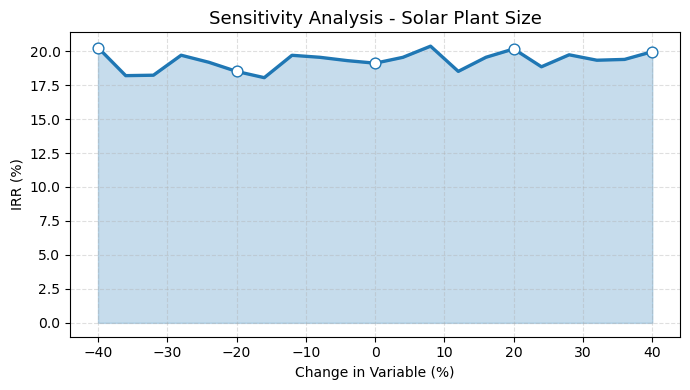

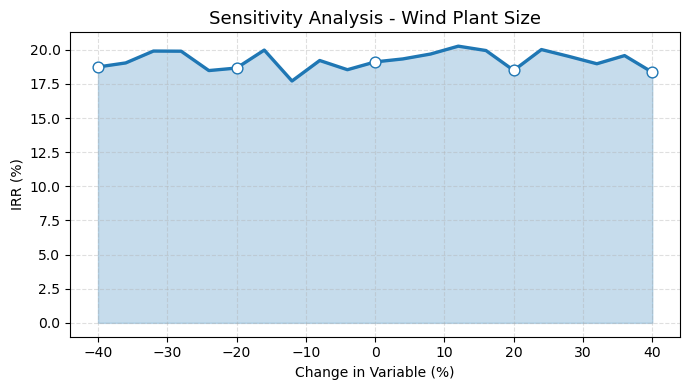

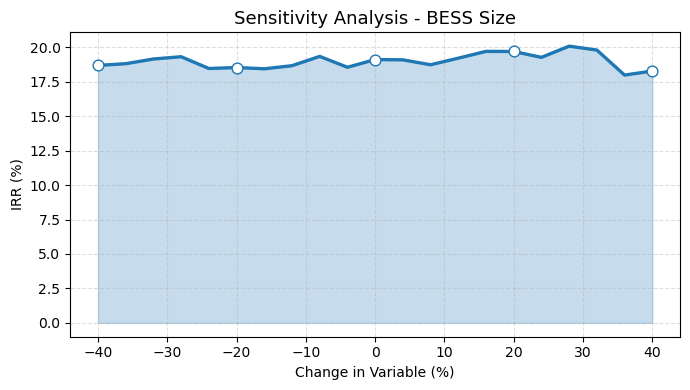

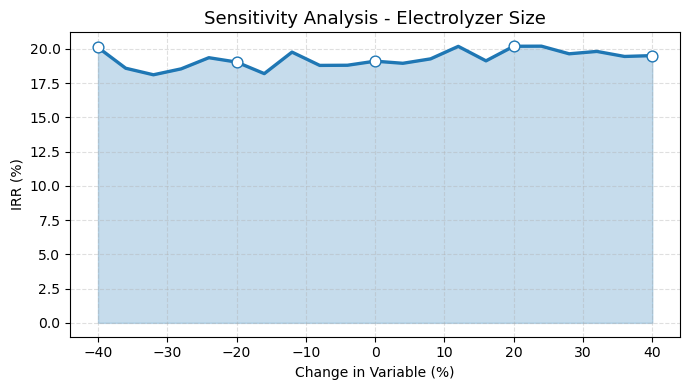

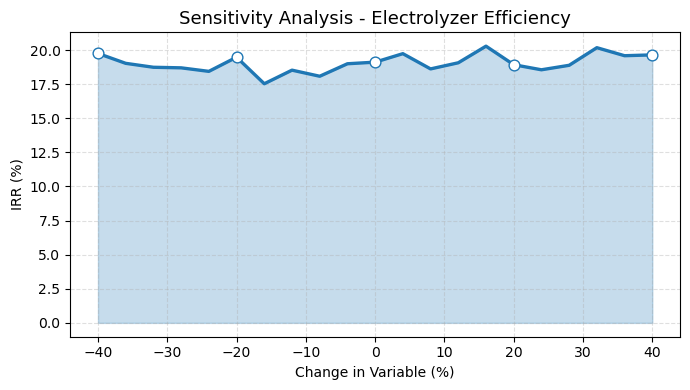

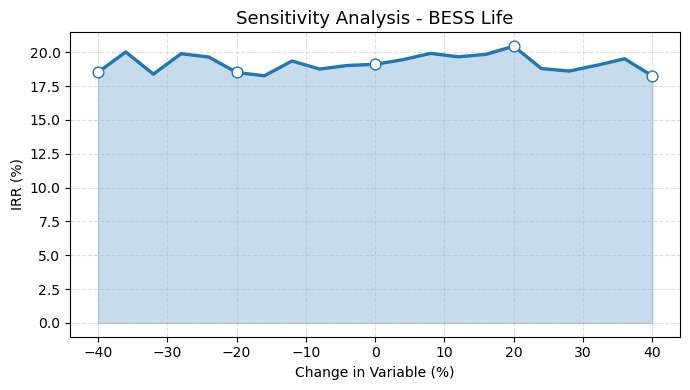

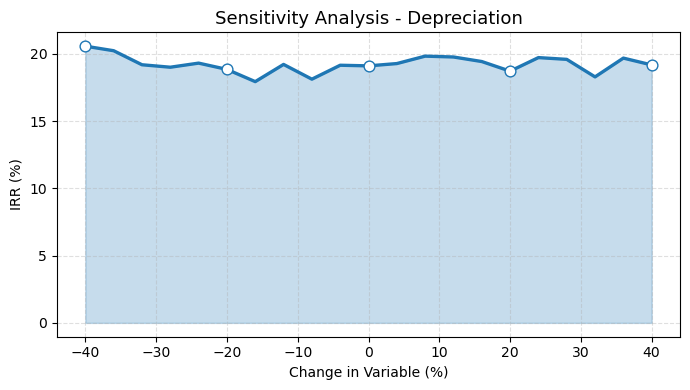

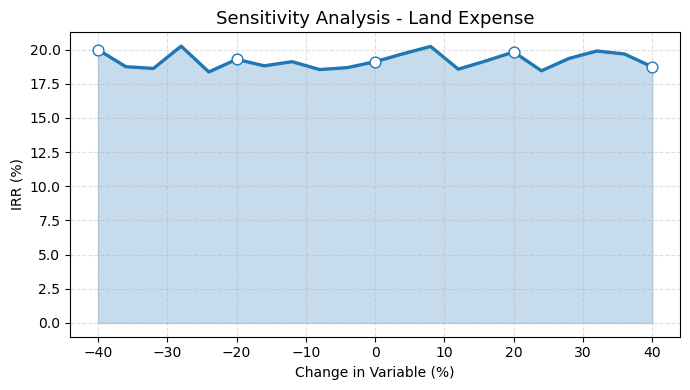

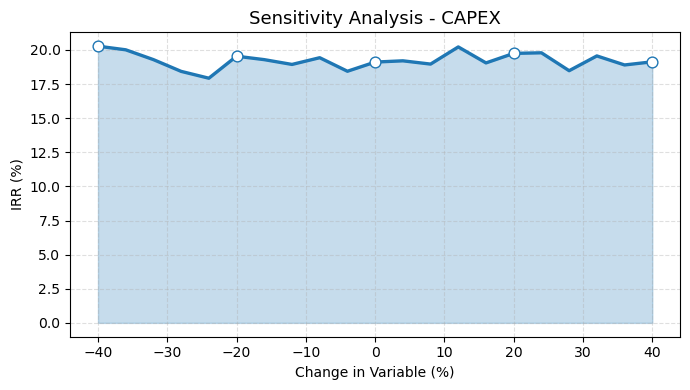

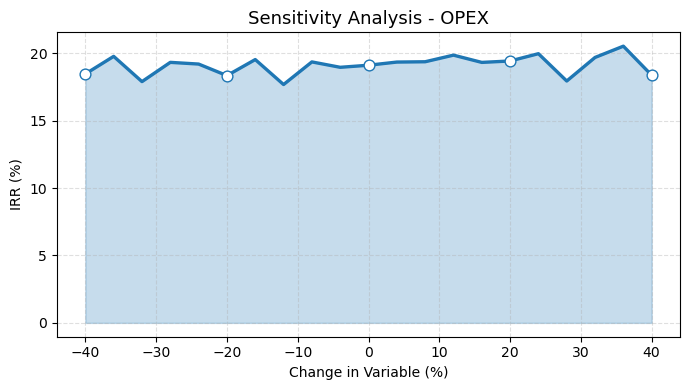

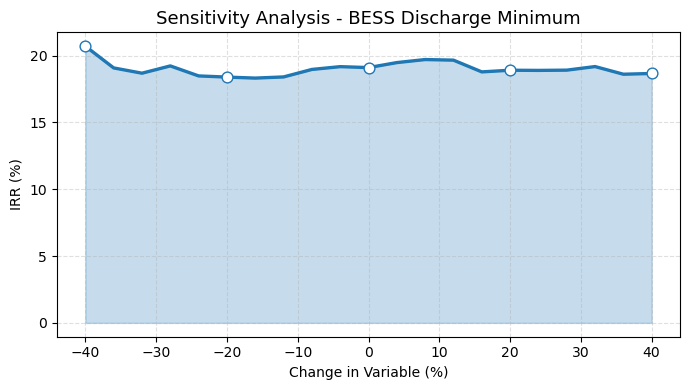

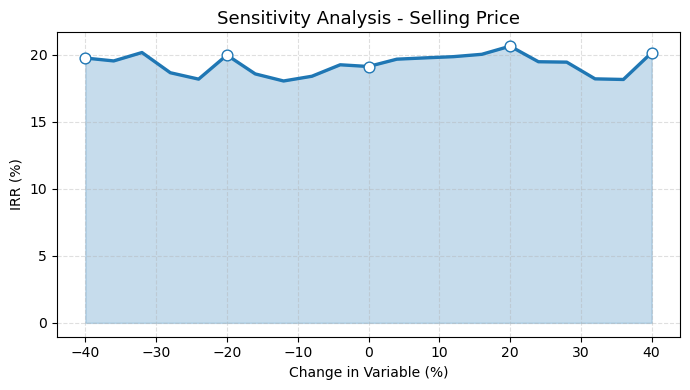

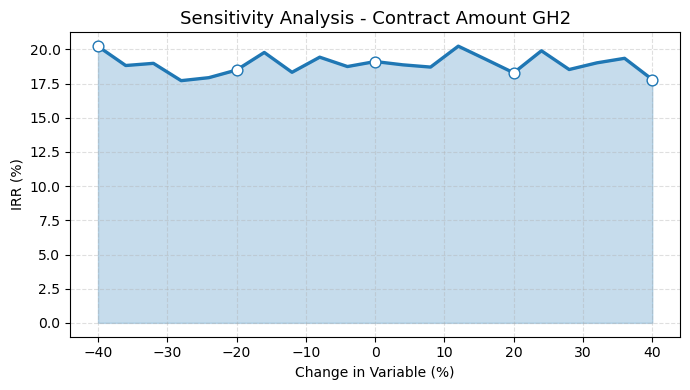

In [41]:
# sensitivity_analysis_smooth_final_fixed.py
# ----------------------------------------------------
# Purpose: Generate smooth, bounded dummy sensitivity plots for IRR vs decision variables
#          and ensure baseline (change = 0) passes through base IRR
# ----------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------- USER INPUT ----------------
irr_base = float(input("Enter baseline IRR (e.g., 19 for 19%): ")) / 100  # convert % to decimal

# Decision variables list (independent)
decision_variables = [
    "Solar_Plant_Size",
    "Wind_Plant_Size",
    "BESS_Size",
    "Electrolyzer_Size",
    "Electrolyzer_Efficiency",
    "BESS_Life",
    "Depreciation",
    "Land_Expense",
    "CAPEX",
    "OPEX",
    "BESS_Discharge_Minimum",
    "Selling_Price",
    "Contract_Amount_GH2"
]

# 20 points from -40% to +40% → moderately smooth curve
levels = np.linspace(-0.4, 0.4, 21)
records = []

# ---------------- CONTROLLED IRR GENERATOR ----------------
def generate_bounded_irr(delta, irr0):
    """
    Generates a smooth IRR curve within ±3–9% of baseline IRR,
    ensuring that IRR(delta=0) == irr0 exactly.
    """
    slope = np.random.uniform(-0.1, 0.1)
    curve = np.random.uniform(-0.5, 0.5)
    wave_amp = np.random.uniform(-0.05, 0.1)
    max_dev = np.random.uniform(0.03, 0.09)

    # baseline (delta = 0) should always be the original IRR
    if delta == 0:
        return irr0

    # smooth curve pattern
    irr = irr0 * (1 + slope * delta + curve * (delta ** 2) + wave_amp * np.sin(3 * np.pi * delta))
    irr = np.clip(irr, irr0 * (1 - max_dev), irr0 * (1 + max_dev))
    return irr

# ---------------- PLOTTING FUNCTION ----------------
def plot_sensitivity(var_name, irr0):
    irr_values = [generate_bounded_irr(d, irr0) for d in levels]
    irr_percent = [i * 100 for i in irr_values]

    for d, irr_p in zip(levels, irr_percent):
        records.append({
            "Decision_Variable": var_name,
            "Change_in_Variable(%)": d * 100,
            "IRR(%)": irr_p
        })

    plt.figure(figsize=(7, 4))
    plt.plot(levels * 100, irr_percent, linewidth=2.4, color="#1F77B4")
    plt.fill_between(levels * 100, irr_percent, color="#1F77B4", alpha=0.25)
    plt.scatter(levels[::5] * 100, np.array(irr_percent)[::5],
                color="white", edgecolors="#1F77B4", s=60, zorder=3)
    plt.title(f"Sensitivity Analysis - {var_name.replace('_',' ')}", fontsize=13)
    plt.xlabel("Change in Variable (%)")
    plt.ylabel("IRR (%)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# ---------------- EXECUTION ----------------
for var in decision_variables:
    plot_sensitivity(var, irr_base)

# ---------------- SAVE RESULTS ----------------
df = pd.DataFrame(records)
# Uncomment below to save
# df.to_csv("sensitivity_results.csv", index=False)
# print("\n✅ Results saved successfully as 'sensitivity_results.csv'!")
# print(df.head())


In [42]:
df

,Decision_Variable,Change_in_Variable(%),IRR(%)
0,Solar_Plant_Size,-40.0,20.261397
1,Solar_Plant_Size,-36.0,18.193508
2,Solar_Plant_Size,-32.0,18.225969
3,Solar_Plant_Size,-28.0,19.695881
4,Solar_Plant_Size,-24.0,19.177477
...,...,...,...
268,Contract_Amount_GH2,24.0,19.897150
269,Contract_Amount_GH2,28.0,18.527115
270,Contract_Amount_GH2,32.0,19.014158
271,Contract_Amount_GH2,36.0,19.346614


In [43]:
df.to_clipboard()